# Gomoku Game with AI Agent

Gomoku is a classic board game, also known as Five in a Row. In this example, we will show 

- How to build a host agent to manage the game board 
- How to build player agent to play the game
- How to build the conversation to play the game

## Prerequisites

- Follow the [README.md](https://github.com/modelscope/agentscope) to install agentscope package. 
- Prepare a model configuration file. You can choose and modify one example configuration from the [example model configs](../example_model_configs) folder according to your needs. 

## Note

- The example is tested with the following models. For other models, you may need to adjust the code accordingly. 
    - gpt-4
    - gpt-3.5-turbo
    - dashscope_chat (qwen-max)
    - ollama_chat (llama3_8b)

## Preparation

Please fill the following cell with your model configurations.

In [1]:
YOUR_MODEL_CONFIGURATION_NAME = "{YOUR_MODEL_CONFIGURATION_NAME}"
YOUR_MODEL_CONFIGURATION = {
    "config_name": YOUR_MODEL_CONFIGURATION_NAME
    
    # ...
}

## Step 1: Prepare a board for Gomoku

First we create a `BoardAgent` class by inheriting from `AgentBase`, which manage the game board and update the game status as follows.

To create a better visual experience, we also provide a function `board2img` to convert the board to an image. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def board2img(board: np.ndarray, save_path: str)->str:
    size = board.shape[0]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, size - 1)
    ax.set_ylim(0, size - 1)
    
    for i in range(size):
        ax.axhline(i, color='black', linewidth=1)
        ax.axvline(i, color='black', linewidth=1)
        
    for y in range(size):
        for x in range(size):
            if board[y, x] == NAME_TO_PIECE[NAME_BLACK]:  # black player
                circle = patches.Circle((x, y), 0.45, 
                                        edgecolor='black', 
                                        facecolor='black',
                                        zorder=10)
                ax.add_patch(circle)
            elif board[y, x] == NAME_TO_PIECE[NAME_WHITE]:  # white player
                circle = patches.Circle((x, y), 0.45, 
                                        edgecolor='black', 
                                        facecolor='white',
                                        zorder=10)
                ax.add_patch(circle)
    # Hide the axes and invert the y-axis
    ax.set_xticks(range(size))
    ax.set_yticks(range(size))
    ax.set_xticklabels(range(size))
    ax.set_yticklabels(range(size))
    ax.invert_yaxis()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)  # Close the figure to free memory
    return save_path

The following code shows the implementation of the `BoardAgent` class. The agent manages the game board and updates the game status.

In [3]:
import numpy as np
from agentscope.message import Msg
from agentscope.agents import AgentBase
from typing import Optional, Union, Sequence

CURRENT_BOARD_PROMPT_TEMPLATE = """The current board is as follows:
{board}
{player}, it's your turn."""

NAME_BLACK = "Alice"
NAME_WHITE = "Bob"

# The mapping from name to piece
NAME_TO_PIECE = {
    NAME_BLACK: "o",
    NAME_WHITE: "x",
}

EMPTY_PIECE = "0"

class BoardAgent(AgentBase):
    
    def __init__(self, name):
        super().__init__(name=name, use_memory=False)
        
        # Init the board
        self.size = 15
        self.board = np.full((self.size, self.size), EMPTY_PIECE)
        
        # Record the status of the game
        self.game_end = False
        
    def reply(self, x: Optional[Union[Msg, Sequence[Msg]]] = None) -> Msg:
        if x is None:
            # Beginning of the game
            content = (
                "Welcome to the Gomoku game! Black player goes first. "
                "Please make your move."
            )
        else:
            row, col = x["content"]

            self.assert_valid_move(row, col)

            # change the board
            self.board[row, col] = NAME_TO_PIECE[x["name"]]

            # check if the game ends
            if self.check_draw():
                content = "The game ends in a draw!"
                self.game_end = True
            else:
                next_player_name = (
                    NAME_BLACK if x["name"] == NAME_WHITE else NAME_WHITE
                )
                content = CURRENT_BOARD_PROMPT_TEMPLATE.format(
                    board=self.board2text(),
                    player=next_player_name,
                )

                if self.check_win(row, col, NAME_TO_PIECE[x["name"]]):
                    content = f"The game ends, {x['name']} wins!"
                    self.game_end = True

        msg_host = Msg(self.name, content, role="assistant")
        self.speak(msg_host)
        
        # Show an image of the board
        img = plt.imread(board2img(self.board, 'current_board.png'))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        return msg_host
                    
    def assert_valid_move(self, x: int, y: int) -> None:
        if not (0 <= x < self.size and 0 <= y < self.size):
            raise RuntimeError(f"Invalid move: {[x, y]} out of board range.")
        
        if not self.board[x, y] == EMPTY_PIECE:
            raise RuntimeError(f"Invalid move: {[x, y]} is already occupied by {self.board[x, y]}.")
    
    def check_win(self, x: int, y: int, piece: str) -> bool:
        xline = self._check_line(self.board[x, :], piece)
        yline = self._check_line(self.board[:, y], piece)
        diag1 = self._check_line(np.diag(self.board, y - x), piece)
        diag2 = self._check_line(np.diag(np.fliplr(self.board), self.size - 1 - x - y), piece)
        return xline or yline or diag1 or diag2

    def check_draw(self) -> bool:
        return np.all(self.board != EMPTY_PIECE)
        
    def board2text(self) -> str:
        return "\n".join([str(_)[1:-1].replace("'", "").replace(" ", "") for _ in self.board])
        
    def _check_line(self, line, piece: str) -> bool:
        count = 0
        for i in line:
            if i == piece:
                count += 1
                if count == 5:
                    return True
            else:
                count = 0
        return False


### Step2: Prepare a Gomoku Player Agent

In Gomoku player agent, we make the following assumptions:
 
1. Agent's response only contains the move (a tuple of location `[x, y]`). Its thought is only recorded in its memory and only visible to itself, enabling the agent to generate strategies. 
2. Within the agent, to enable the agent to think, we ask LLMs to respond in a dictionary format, which contains the thought and the move ("thought" field must come before "move"). To achieve this, we prepare a parsing function to extract the dictionary from response. 

The implementation of the Gomoku agent is as follows: 

In [4]:
import json
from agentscope.models import ModelResponse
from typing import Optional, Union, Sequence

SYS_PROMPT_TEMPLATE = """
You're a skillful Gomoku player. You should play against your opponent according to the following rules:

Game Rules:
1. This Gomoku board is a 15*15 grid. Moves are made by specifying row and column indexes, with [0, 0] marking the top-left corner and [14, 14] indicating the bottom-right corner.
2. The goal is to be the first player to form an unbroken line of your pieces horizontally, vertically, or diagonally. 
3. If the board is completely filled with pieces and no player has formed a row of five, the game is declared a draw.

Note: 
1. Your pieces are represented by '{}', your opponent's by '{}'. 0 represents an empty spot on the board. 
2. You should think carefully about your strategy and moves, considering both your and your opponent's subsequent moves. 
3. Make sure you don't place your piece on a spot that has already been occupied. 
4. Only an unbroken line of five same pieces will win the game. For example, "xxxoxx" won't be considered a win. 
5. Note the unbroken line can be formed in any direction: horizontal, vertical, or diagonal.
"""

HINT_PROMPT = """You should respond in the following format, which can be loaded by json.loads in Python:
{{
    "thought": "analyze the present situation, and what move you should make",
    "move": [row index, column index]
}}
"""


def parse_func(response: ModelResponse) -> ModelResponse:
    res_dict = json.loads(response.text)
    if "move" in res_dict and "thought" in res_dict:
        return ModelResponse(raw=res_dict)
    else:
        raise ValueError(f"Invalid response format in parse_func with response: {response.text}")

class GomokuAgent(AgentBase):
    """A Gomoku agent that can play the game with another agent."""
    
    def __init__(self, name, sys_prompt, model_config_name):
        super().__init__(name=name, sys_prompt=sys_prompt, model_config_name=model_config_name)
        
        self.memory.add(Msg("system", sys_prompt, role="system"))
        
    def reply(self, x: Optional[Union[Msg, Sequence[Msg]]] = None) -> Msg:
        if self.memory:
            self.memory.add(x)
        
        msg_hint = Msg("system", HINT_PROMPT, role="system")
        
        prompt = self.model.format(
            self.memory.get_memory(),
            msg_hint,     
        )
        
        response = self.model(
            prompt,
            parse_func=parse_func,
            max_retries=3,
        ).raw
        
        # For better presentation, we print the response proceeded by json.dumps, this msg won't be recorded in memory
        self.speak(Msg(self.name, json.dumps(response, indent=4, ensure_ascii=False), role="assistant"))
        
        if self.memory:
            self.memory.add(Msg(self.name, response, role="assistant"))
        
        # Hide thought from the response
        return Msg(self.name, response["move"], role="assistant") 


Now, let's create two AI agents, named "Alice" and "Bob," who will engage in the Gomoku game, and a board agent. Creating agents is straightforward. 

In [5]:
import agentscope

agentscope.init(
    model_configs=YOUR_MODEL_CONFIGURATION,
    project="Gomoku",    
)

piece_black = NAME_TO_PIECE[NAME_BLACK]
piece_white = NAME_TO_PIECE[NAME_WHITE]

black = GomokuAgent(
    NAME_BLACK,
    model_config_name=YOUR_MODEL_CONFIGURATION_NAME,
    sys_prompt=SYS_PROMPT_TEMPLATE.format(piece_black, piece_white),
)
                    
white = GomokuAgent(
    NAME_WHITE,
    model_config_name=YOUR_MODEL_CONFIGURATION_NAME,
    sys_prompt=SYS_PROMPT_TEMPLATE.format(piece_white, piece_black),
)

board = BoardAgent(name="Host")

2024-03-27 16:09:59.427 | INFO     | agentscope.models:read_model_configs:171 - Load configs for model wrapper: post_api
2024-03-27 16:09:59.435 | INFO     | agentscope.utils.monitor:_create_monitor_table:341 - Init [monitor_metrics] as the monitor table
2024-03-27 16:09:59.435 | INFO     | agentscope.utils.monitor:_create_monitor_table:342 - Init [monitor_metrics_quota_exceeded] as the monitor trigger
2024-03-27 16:09:59.436 | INFO     | agentscope.utils.monitor:__init__:311 - SqliteMonitor initialization completed at [./runs/run_20240327-160958_kbf2ta/agentscope.db]
2024-03-27 16:09:59.440 | INFO     | agentscope.models.model:__init__:257 - Initialize model [post_api]
2024-03-27 16:09:59.441 | INFO     | agentscope.models.model:__init__:257 - Initialize model [post_api]


### Step 3: Start the Gomoku game

The game logic is simple in Gomoku, where two players take turns to make a move. The game ends when one player wins or the board is full. 

In this game, we use a message hub to share messages between the two players (board agent doesn't have memory), so that one player can hear what the board agent says to the other player, and what moves the other player makes. 

Note here we only show 10 steps of the game. You can adjust the `MAX_STEPS` to play more rounds.

Host: Welcome to the Gomoku game! Black player goes first. Please make your move.


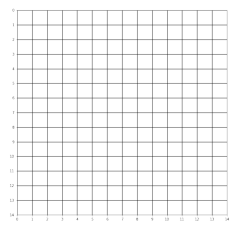

Alice: {
    "thought": "As the first move of the game, it's best to place the piece in the center of the board to maximize possible winning directions.",
    "move": [
        7,
        7
    ]
}
Host: The current board is as follows:
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
0000000o0000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
Bob, it's your turn.


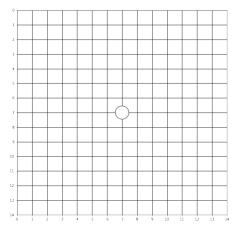

Bob: {
    "thought": "As the game has just started, I will place my piece near Alice's to prevent her from forming a line and to start building my own line.",
    "move": [
        7,
        8
    ]
}
Host: The current board is as follows:
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
0000000ox000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
Alice, it's your turn.


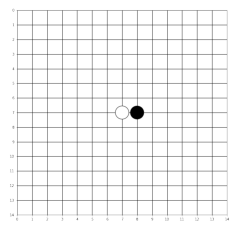

Alice: {
    "thought": "My opponent placed his piece next to mine. I should block him and also try to create a potential line for myself.",
    "move": [
        7,
        6
    ]
}
Host: The current board is as follows:
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000oox000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
Bob, it's your turn.


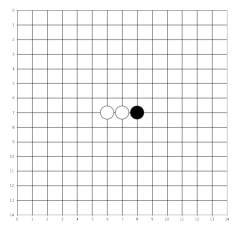

Bob: {
    "thought": "I see Alice is trying to create a line horizontally. I need to block her next move otherwise she will have a chance to win. I will place my piece at [7, 5].",
    "move": [
        7,
        5
    ]
}
Host: The current board is as follows:
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
00000xoox000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
Alice, it's your turn.


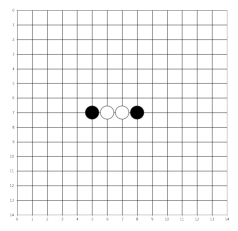

Alice: {
    "thought": "My opponent is trying to block me. I should place my piece at [7, 9] to create a potential line for myself.",
    "move": [
        7,
        9
    ]
}
Host: The current board is as follows:
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
00000xooxo00000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
Bob, it's your turn.


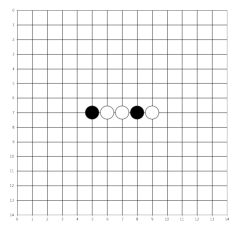

Bob: {
    "thought": "Alice is trying to create a line horizontally again. I need to block her next move otherwise she will have a chance to win. I will place my piece at [7, 10].",
    "move": [
        7,
        10
    ]
}
Host: The current board is as follows:
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
00000xooxox0000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
Alice, it's your turn.


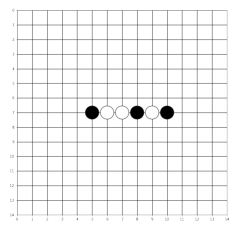

Alice: {
    "thought": "My opponent is trying to block me. I should place my piece at [6, 7] to create a potential line for myself.",
    "move": [
        6,
        7
    ]
}
Host: The current board is as follows:
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
0000000o0000000
00000xooxox0000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
Bob, it's your turn.


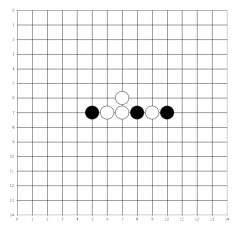

Bob: {
    "thought": "Alice is trying to build a vertical line now. I need to block her next move otherwise she will have a chance to win. I will place my piece at [5, 7].",
    "move": [
        5,
        7
    ]
}
Host: The current board is as follows:
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
0000000x0000000
0000000o0000000
00000xooxox0000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
Alice, it's your turn.


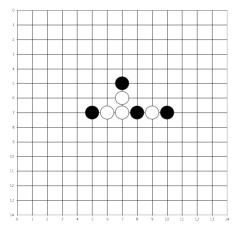

Alice: {
    "thought": "My opponent is trying to block me. I should place my piece at [8, 7] to create a potential line for myself.",
    "move": [
        8,
        7
    ]
}
Host: The current board is as follows:
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
0000000x0000000
0000000o0000000
00000xooxox0000
0000000o0000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
000000000000000
Bob, it's your turn.


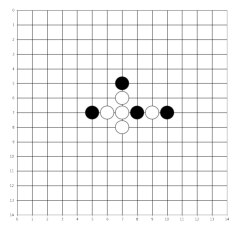

Bob: {
    "thought": "Alice is trying to build a vertical line again. I need to block her next move otherwise she will have a chance to win. I will place my piece at [9, 7].",
    "move": [
        9,
        7
    ]
}


In [6]:
from agentscope import msghub

MAX_STEPS = 10

msg = None
i = 0

# Use a msg hub to share conversation between two players, e.g. white player can hear what black player says to the board
with msghub(participants=[black, white, board]):
    while not board.game_end and i < MAX_STEPS:
        for player in [black, white]:
            # receive the move from the player, judge if the game ends and remind the player to make a move
            msg = board(msg)
            
            # end the game if draw or win 
            if board.game_end:
                break
                
            # make a move
            msg = player(msg)
            
            i += 1

## Future Direction

This is only a simple example for Gomoku with AI agents. To further improve the game, you can try:

- Use `agentscope.agents.UserAgent` to replace one player agent, so you can participate in the game
- Use a reasoning algorithm within the agent to make a better move
- Fine tune a model to improve the performance of the agent

For complete code, we provide in [code/game_gomoku.py](./code/game_gomoku.py).